In [1]:
# Step 1: 데이터 크기 확인하기

import os
import numpy as np

# 폴더 경로
folder_path = 'NpyFiles'

# 모든 파일의 크기 확인
file_shapes = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(folder_path, filename)
        data = np.load(file_path)
        file_shapes[filename] = data.shape

# 기준 크기 (첫 번째 파일의 크기)
reference_shape = list(file_shapes.values())[0]

# 크기가 다른 파일들 찾기
different_shapes = {filename: shape for filename, shape in file_shapes.items() if shape != reference_shape}

# 결과 출력
print(f"기준 크기: {reference_shape}")
if different_shapes:
    print("크기가 다른 파일들:")
    for filename, shape in different_shapes.items():
        print(f"{filename}: {shape}")
else:
    print("모든 파일의 크기가 동일합니다.")

기준 크기: (1230, 10, 60)
모든 파일의 크기가 동일합니다.


In [3]:
# Step 2: 데이터 로드 및 결합
import numpy as np

actions = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ',
           'ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ',
           'ㅐ', 'ㅒ', 'ㅔ', 'ㅖ', 'ㅢ', 'ㅚ', 'ㅟ']

data = np.concatenate([np.load(f'NpyFiles/seq_{action}.npy') for action in actions], axis=0)

print("데이터 로드 및 결합 완료")
print(f"데이터 형태: {data.shape}")


데이터 로드 및 결합 완료
데이터 형태: (38130, 10, 60)


In [5]:
# Step 3: 데이터 분리 및 전처리
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(f"x_data 형태: {x_data.shape}")
print(f"labels 형태: {labels.shape}")

from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
print(f"y_data 형태: {y_data.shape}")


x_data 형태: (38130, 10, 59)
labels 형태: (38130,)
y_data 형태: (38130, 31)


In [6]:
# Step 4: 데이터셋 분할
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2020)

print(f"x_train 형태: {x_train.shape}, y_train 형태: {y_train.shape}")
print(f"x_val 형태: {x_val.shape}, y_val 형태: {y_val.shape}")


x_train 형태: (30504, 10, 59), y_train 형태: (30504, 31)
x_val 형태: (7626, 10, 59), y_val 형태: (7626, 31)


In [7]:
# Step 5.1: LSTM 모델 정의 및 컴파일
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras as keras

tf.random.set_seed(42)

# custom f1 score
def metric_F1score(y_true, y_pred):
    TP = tf.reduce_sum(y_true * tf.round(y_pred))
    FP = tf.reduce_sum((1 - y_true) * tf.round(y_pred))
    FN = tf.reduce_sum(y_true * (1 - tf.round(y_pred)))
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1score = 2 * precision * recall / (precision + recall)
    return F1score

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3], kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                31744     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 31)                1023      
                                                                 
Total params: 34,847
Trainable params: 34,847
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Step 5.2: GRU 모델 정의 및 컴파일
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import tensorflow.keras as keras

tf.random.set_seed(42)

# custom f1 score
def metric_F1score(y_true, y_pred):
    TP = tf.reduce_sum(y_true * tf.round(y_pred))
    FP = tf.reduce_sum((1 - y_true) * tf.round(y_pred))
    FN = tf.reduce_sum(y_true * (1 - tf.round(y_pred)))
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1score = 2 * precision * recall / (precision + recall)
    return F1score

gru_model = Sequential([
    GRU(64, activation='relu', input_shape=x_train.shape[1:3], kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])
gru_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                24000     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 31)                1023      
                                                                 
Total params: 27,103
Trainable params: 27,103
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Step 5.3: 1D-CNN 모델 정의 및 컴파일
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=x_train.shape[1:]),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             11392     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [10]:
# Step 5.4: Bi-LSTM 모델 정의 및 컴파일
from tensorflow.keras.layers import Bidirectional, LSTM

bilstm_model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=True, input_shape=x_train.shape[1:3])),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
])

bilstm_model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])
bilstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 128)          63488     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 31)               

In [11]:
# Step 5.5: Bi-GRU 모델 정의 및 컴파일
from tensorflow.keras.layers import Bidirectional, GRU

bigru_model = Sequential([
    Bidirectional(GRU(64, activation='relu', return_sequences=True, input_shape=x_train.shape[1:3])),
    Bidirectional(GRU(32, activation='relu')),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
])

bigru_model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))
bigru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])
bigru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 10, 128)          48000     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 31)               

In [12]:
# Step 6.1: LSTM 모델 훈련
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor='val_metric_F1score', min_delta=0, patience=20, mode='auto')

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/sign_language_classifier_lstm.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto'),
        early_stopping
    ]
)

Epoch 1/200
949/954 [============================>.] - ETA: 0s - loss: 5.7396 - acc: 0.2239 - metric_F1score: nan
Epoch 1: val_acc improved from -inf to 0.58209, saving model to models\sign_language_classifier_lstm.h5
954/954 [==============================] - 13s 10ms/step - loss: 5.7256 - acc: 0.2247 - metric_F1score: nan - val_loss: 2.2607 - val_acc: 0.5821 - val_metric_F1score: 0.4349 - lr: 0.0010
Epoch 2/200
949/954 [============================>.] - ETA: 0s - loss: 2.3037 - acc: 0.4823 - metric_F1score: 0.4794
Epoch 2: val_acc improved from 0.58209 to 0.71033, saving model to models\sign_language_classifier_lstm.h5
954/954 [==============================] - 9s 9ms/step - loss: 2.3030 - acc: 0.4824 - metric_F1score: 0.4794 - val_loss: 1.5246 - val_acc: 0.7103 - val_metric_F1score: 0.6379 - lr: 0.0010
Epoch 3/200
954/954 [==============================] - ETA: 0s - loss: 1.6841 - acc: 0.6092 - metric_F1score: 0.6199
Epoch 3: val_acc improved from 0.71033 to 0.84881, saving model to

In [14]:
# Step 6.2: GRU 모델 훈련
gru_history = gru_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/sign_language_classifier_gru.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_metric_F1score', min_delta=0, patience=20, mode='auto')
    ]
)


Epoch 1/200
947/954 [============================>.] - ETA: 0s - loss: 0.4291 - acc: 0.9211 - metric_F1score: 0.9190
Epoch 1: val_acc improved from -inf to 0.96984, saving model to models\sign_language_classifier_gru.h5
954/954 [==============================] - 7s 8ms/step - loss: 0.4284 - acc: 0.9214 - metric_F1score: 0.9192 - val_loss: 0.2556 - val_acc: 0.9698 - val_metric_F1score: 0.9701 - lr: 0.0010
Epoch 2/200
953/954 [============================>.] - ETA: 0s - loss: 0.4149 - acc: 0.9257 - metric_F1score: 0.9229
Epoch 2: val_acc did not improve from 0.96984
954/954 [==============================] - 7s 7ms/step - loss: 0.4149 - acc: 0.9257 - metric_F1score: 0.9230 - val_loss: 0.2578 - val_acc: 0.9692 - val_metric_F1score: 0.9695 - lr: 0.0010
Epoch 3/200
950/954 [============================>.] - ETA: 0s - loss: 0.4059 - acc: 0.9273 - metric_F1score: 0.9254
Epoch 3: val_acc improved from 0.96984 to 0.97194, saving model to models\sign_language_classifier_gru.h5
954/954 [=========

Epoch 24/200
954/954 [==============================] - ETA: 0s - loss: 0.3830 - acc: 0.9348 - metric_F1score: 0.9333
Epoch 24: val_acc did not improve from 0.97194
954/954 [==============================] - 8s 8ms/step - loss: 0.3830 - acc: 0.9348 - metric_F1score: 0.9333 - val_loss: 0.3249 - val_acc: 0.9512 - val_metric_F1score: 0.9519 - lr: 0.0010
Epoch 25/200
954/954 [==============================] - ETA: 0s - loss: 0.4710 - acc: 0.9178 - metric_F1score: 0.9160
Epoch 25: val_acc did not improve from 0.97194
954/954 [==============================] - 8s 8ms/step - loss: 0.4710 - acc: 0.9178 - metric_F1score: 0.9160 - val_loss: 0.2931 - val_acc: 0.9628 - val_metric_F1score: 0.9623 - lr: 0.0010
Epoch 26/200
951/954 [============================>.] - ETA: 0s - loss: 0.4065 - acc: 0.9311 - metric_F1score: 0.9310
Epoch 26: val_acc did not improve from 0.97194
954/954 [==============================] - 7s 7ms/step - loss: 0.4070 - acc: 0.9311 - metric_F1score: 0.9310 - val_loss: 0.3027 -

950/954 [============================>.] - ETA: 0s - loss: 0.3782 - acc: 0.9398 - metric_F1score: 0.9393
Epoch 47: val_acc did not improve from 0.97194
954/954 [==============================] - 7s 8ms/step - loss: 0.3784 - acc: 0.9397 - metric_F1score: 0.9393 - val_loss: 0.2578 - val_acc: 0.9659 - val_metric_F1score: 0.9662 - lr: 0.0010
Epoch 48/200
951/954 [============================>.] - ETA: 0s - loss: 0.3955 - acc: 0.9360 - metric_F1score: 0.9350
Epoch 48: val_acc did not improve from 0.97194
954/954 [==============================] - 7s 8ms/step - loss: 0.3953 - acc: 0.9360 - metric_F1score: 0.9350 - val_loss: 0.2797 - val_acc: 0.9611 - val_metric_F1score: 0.9621 - lr: 0.0010
Epoch 49/200
948/954 [============================>.] - ETA: 0s - loss: 0.3746 - acc: 0.9395 - metric_F1score: 0.9385
Epoch 49: val_acc did not improve from 0.97194
954/954 [==============================] - 7s 8ms/step - loss: 0.3745 - acc: 0.9395 - metric_F1score: 0.9383 - val_loss: 0.3091 - val_acc: 0.9

954/954 [==============================] - ETA: 0s - loss: 0.4200 - acc: 0.9340 - metric_F1score: 0.9336
Epoch 70: val_acc did not improve from 0.97194
954/954 [==============================] - 9s 9ms/step - loss: 0.4200 - acc: 0.9340 - metric_F1score: 0.9336 - val_loss: 0.2778 - val_acc: 0.9688 - val_metric_F1score: 0.9692 - lr: 0.0010
Epoch 71/200
948/954 [============================>.] - ETA: 0s - loss: 0.5045 - acc: 0.9113 - metric_F1score: 0.9098
Epoch 71: val_acc did not improve from 0.97194
954/954 [==============================] - 7s 7ms/step - loss: 0.5039 - acc: 0.9115 - metric_F1score: 0.9100 - val_loss: 0.3060 - val_acc: 0.9633 - val_metric_F1score: 0.9639 - lr: 0.0010
Epoch 72/200
949/954 [============================>.] - ETA: 0s - loss: 0.5185 - acc: 0.9103 - metric_F1score: 0.9095
Epoch 72: val_acc did not improve from 0.97194
954/954 [==============================] - 7s 8ms/step - loss: 0.5195 - acc: 0.9099 - metric_F1score: 0.9090 - val_loss: 0.4600 - val_acc: 0.9

In [15]:
# Step 6.3: 1D-CNN 모델 훈련
cnn_history = cnn_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/sign_language_classifier_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_metric_F1score', min_delta=0, patience=20, mode='auto')
    ]
)

Epoch 1/200
951/954 [============================>.] - ETA: 0s - loss: 1.7670 - acc: 0.7513 - metric_F1score: nan
Epoch 1: val_acc improved from -inf to 0.95306, saving model to models\sign_language_classifier_cnn.h5
954/954 [==============================] - 6s 5ms/step - loss: 1.7648 - acc: 0.7517 - metric_F1score: nan - val_loss: 0.6890 - val_acc: 0.9531 - val_metric_F1score: 0.9510 - lr: 0.0010
Epoch 2/200
950/954 [============================>.] - ETA: 0s - loss: 0.5884 - acc: 0.9349 - metric_F1score: 0.9321
Epoch 2: val_acc improved from 0.95306 to 0.96171, saving model to models\sign_language_classifier_cnn.h5
954/954 [==============================] - 5s 5ms/step - loss: 0.5875 - acc: 0.9351 - metric_F1score: 0.9324 - val_loss: 0.3781 - val_acc: 0.9617 - val_metric_F1score: 0.9614 - lr: 0.0010
Epoch 3/200
938/954 [============================>.] - ETA: 0s - loss: 0.3515 - acc: 0.9520 - metric_F1score: 0.9513
Epoch 3: val_acc improved from 0.96171 to 0.97325, saving model to mod

In [16]:
# Step 6.4: Bi-LSTM 모델 훈련
bilstm_history = bilstm_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/sign_language_classifier_bilstm.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_metric_F1score', min_delta=0, patience=20, mode='auto')
    ]
)

Epoch 1/200
954/954 [==============================] - ETA: 0s - loss: 6.8268 - acc: 0.2091 - metric_F1score: nan
Epoch 1: val_acc improved from -inf to 0.47469, saving model to models\sign_language_classifier_bilstm.h5
954/954 [==============================] - 22s 17ms/step - loss: 6.8268 - acc: 0.2091 - metric_F1score: nan - val_loss: 2.4750 - val_acc: 0.4747 - val_metric_F1score: 0.4432 - lr: 0.0010
Epoch 2/200
951/954 [============================>.] - ETA: 0s - loss: 2.5082 - acc: 0.4112 - metric_F1score: 0.4279
Epoch 2: val_acc improved from 0.47469 to 0.66208, saving model to models\sign_language_classifier_bilstm.h5
954/954 [==============================] - 16s 17ms/step - loss: 2.5073 - acc: 0.4114 - metric_F1score: 0.4285 - val_loss: 1.6230 - val_acc: 0.6621 - val_metric_F1score: 0.6059 - lr: 0.0010
Epoch 3/200
951/954 [============================>.] - ETA: 0s - loss: 2.0634 - acc: 0.4743 - metric_F1score: 0.4945
Epoch 3: val_acc improved from 0.66208 to 0.67506, saving mo

In [17]:
# Step 6.4: Bi-GRU 모델 훈련
bigru_history = bigru_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/sign_language_classifier_bigru.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_metric_F1score', min_delta=0, patience=20, mode='auto')
    ]
)

Epoch 1/200
952/954 [============================>.] - ETA: 0s - loss: 2.1713 - acc: 0.5356 - metric_F1score: nan
Epoch 1: val_acc improved from -inf to 0.93312, saving model to models\sign_language_classifier_bigru.h5
954/954 [==============================] - 25s 20ms/step - loss: 2.1698 - acc: 0.5360 - metric_F1score: nan - val_loss: 0.5387 - val_acc: 0.9331 - val_metric_F1score: 0.9279 - lr: 0.0010
Epoch 2/200
951/954 [============================>.] - ETA: 0s - loss: 0.7038 - acc: 0.8510 - metric_F1score: 0.8488
Epoch 2: val_acc improved from 0.93312 to 0.95555, saving model to models\sign_language_classifier_bigru.h5
954/954 [==============================] - 18s 19ms/step - loss: 0.7034 - acc: 0.8511 - metric_F1score: 0.8490 - val_loss: 0.3140 - val_acc: 0.9555 - val_metric_F1score: 0.9555 - lr: 0.0010
Epoch 3/200
952/954 [============================>.] - ETA: 0s - loss: 0.4623 - acc: 0.9026 - metric_F1score: 0.9012
Epoch 3: val_acc improved from 0.95555 to 0.96748, saving mode

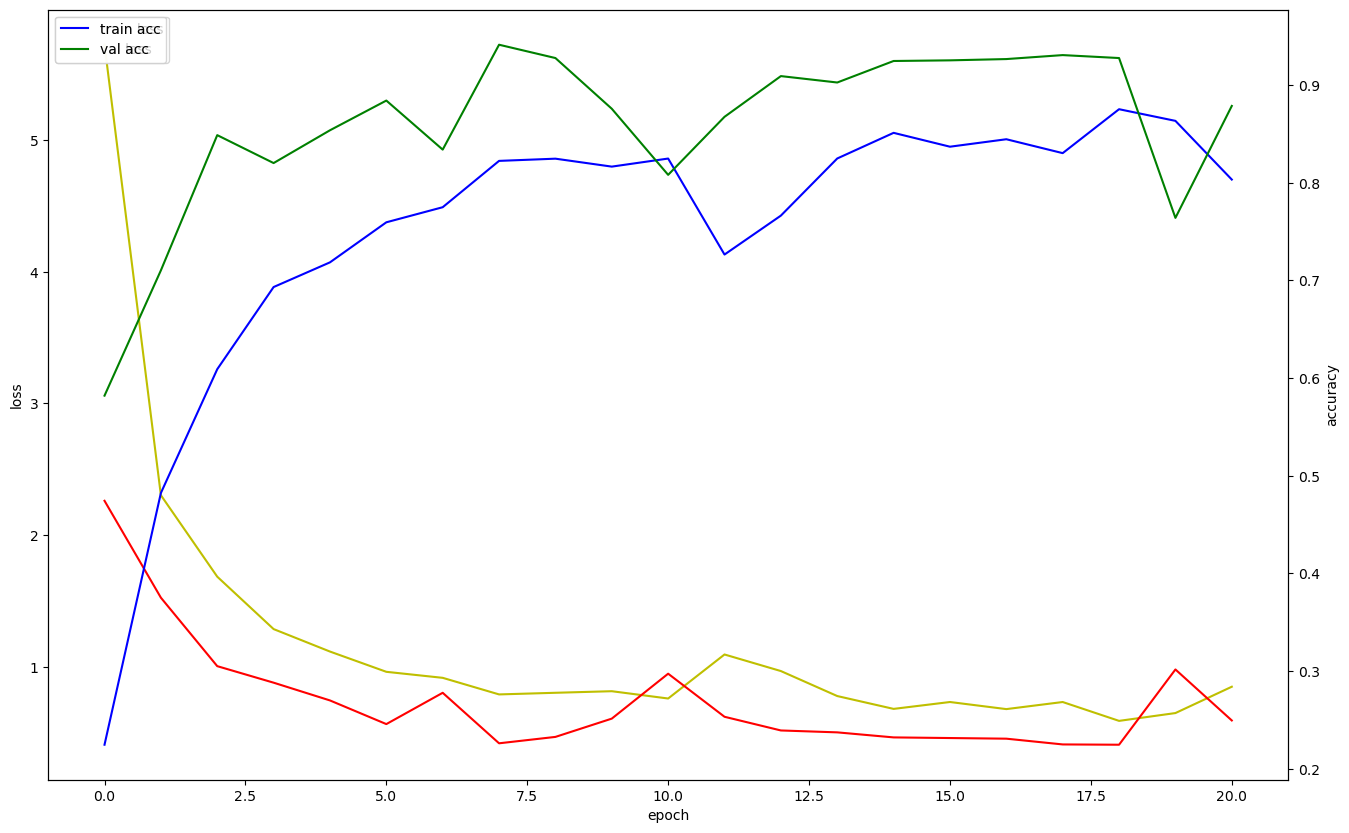

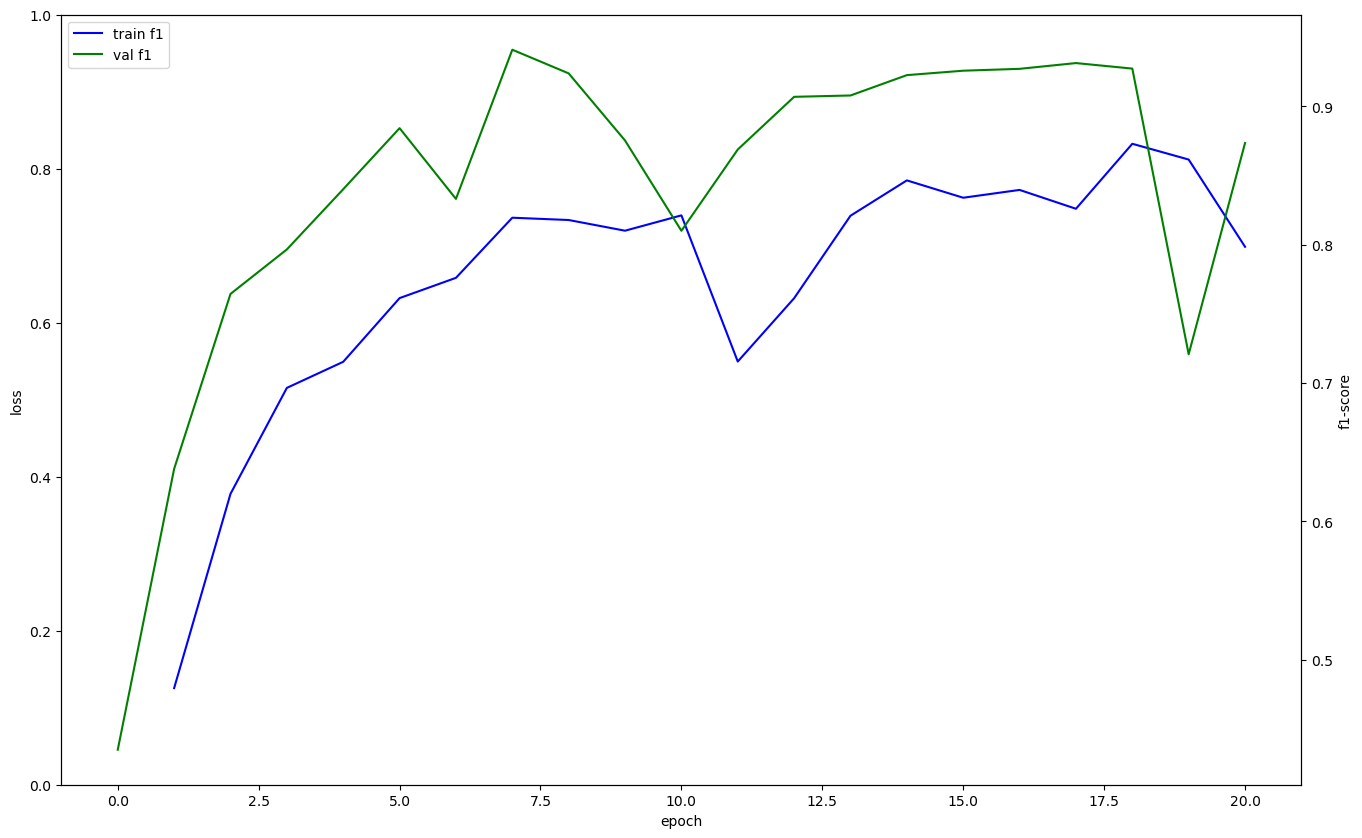

In [19]:
# Step 7.1: LSTM 훈련 결과 시각화
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

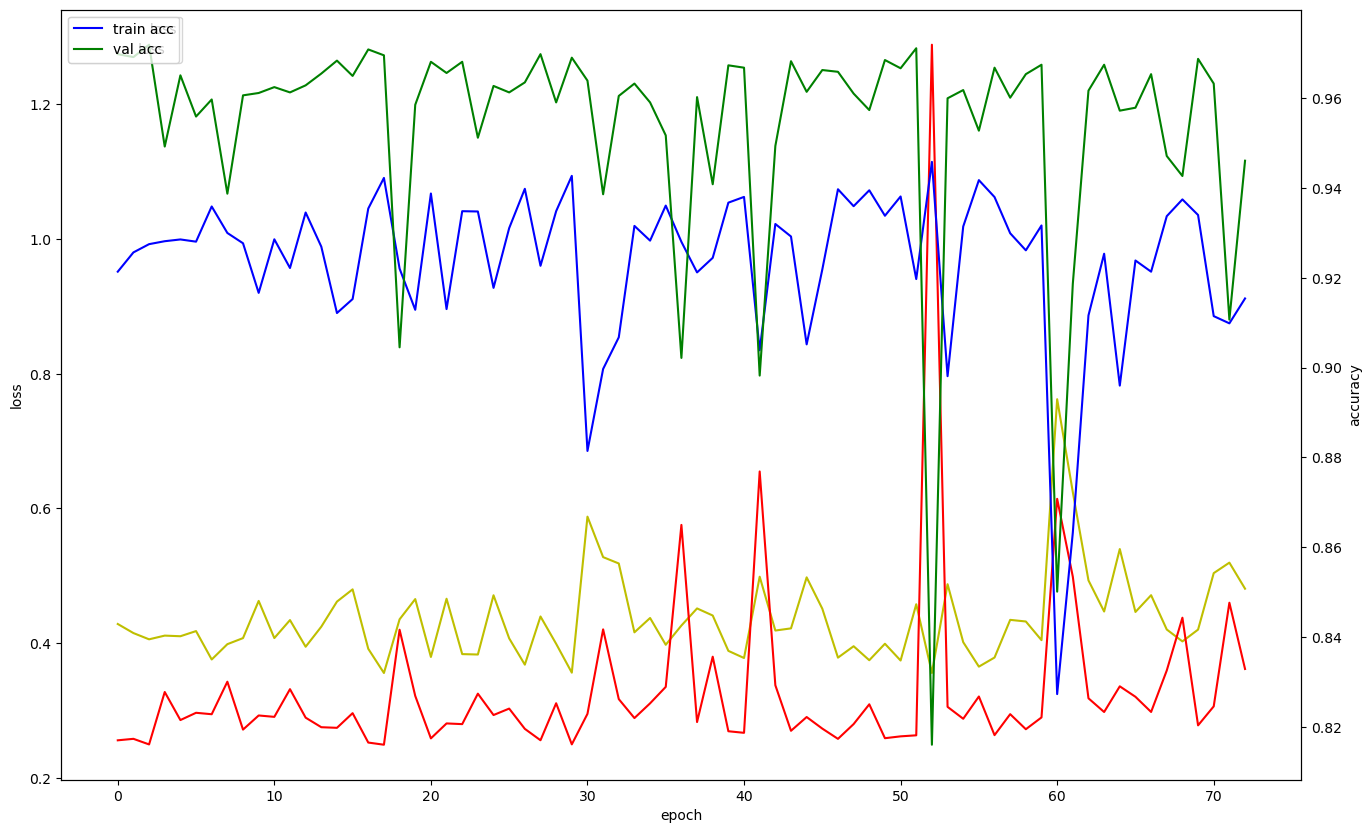

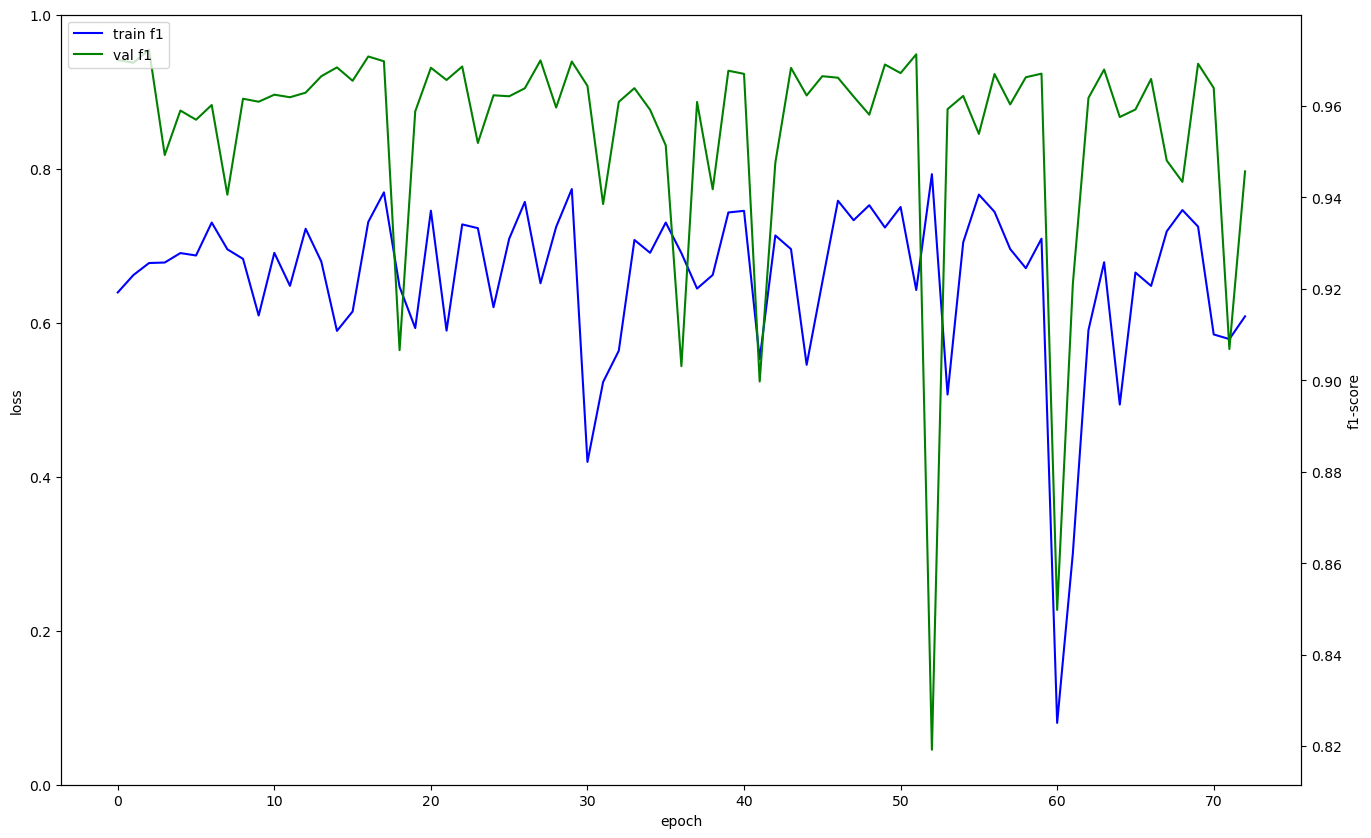

In [20]:
# Step 7.2: GRU 모델 결과 시각화
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(gru_history.history['loss'], 'y', label='train loss')
loss_ax.plot(gru_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(gru_history.history['acc'], 'b', label='train acc')
acc_ax.plot(gru_history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(gru_history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(gru_history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

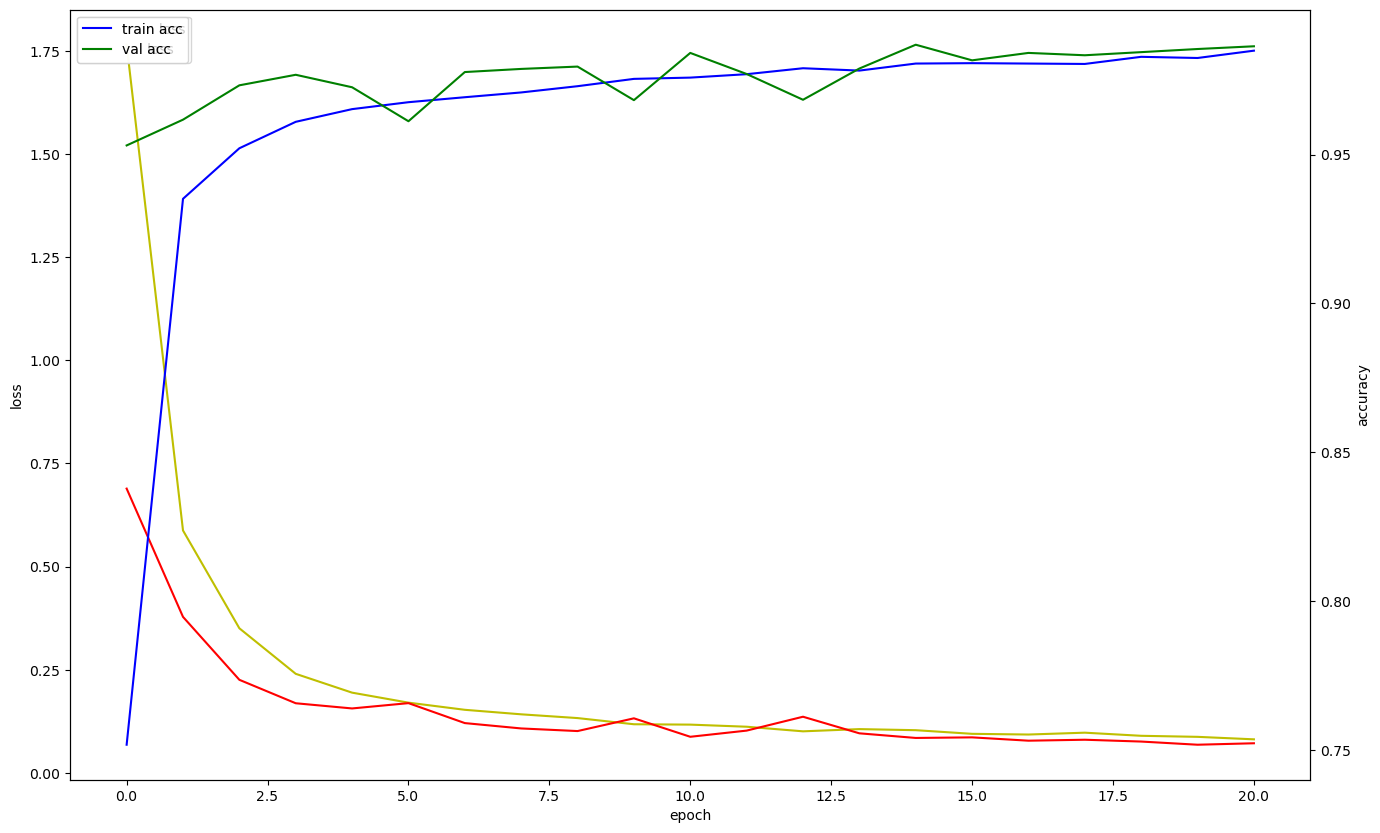

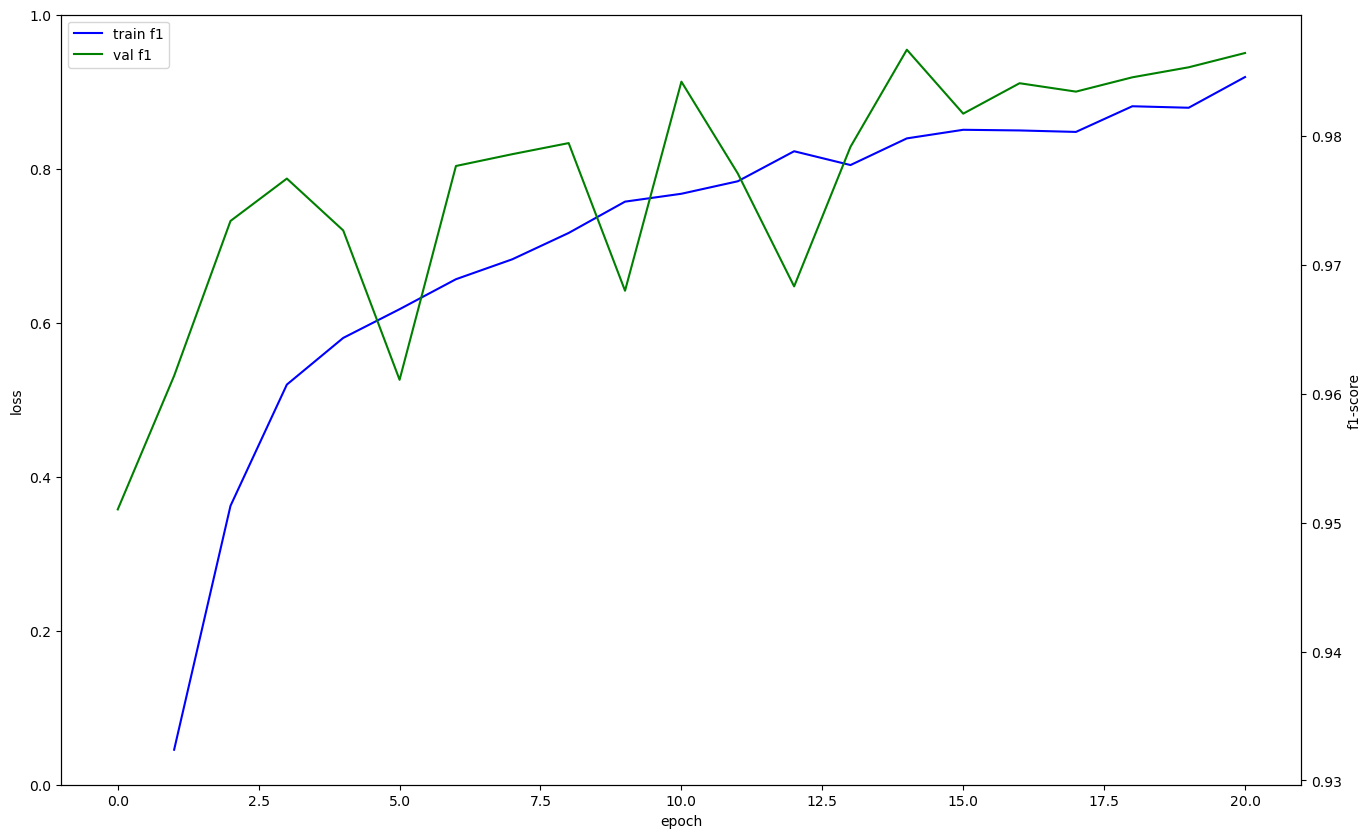

In [21]:
# Step 7.3: 1D-CNN 모델 결과 시각화
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(cnn_history.history['loss'], 'y', label='train loss')
loss_ax.plot(cnn_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(cnn_history.history['acc'], 'b', label='train acc')
acc_ax.plot(cnn_history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(cnn_history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(cnn_history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()


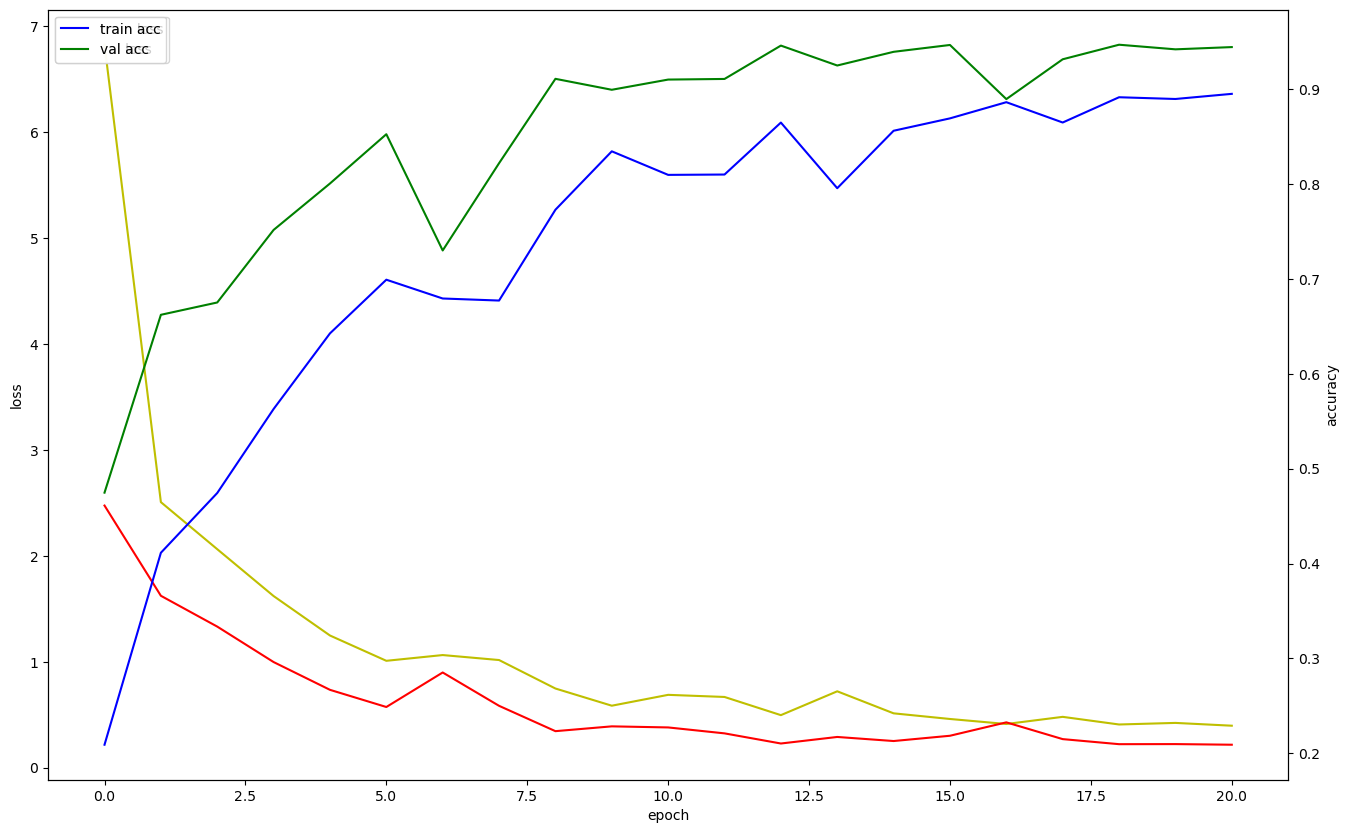

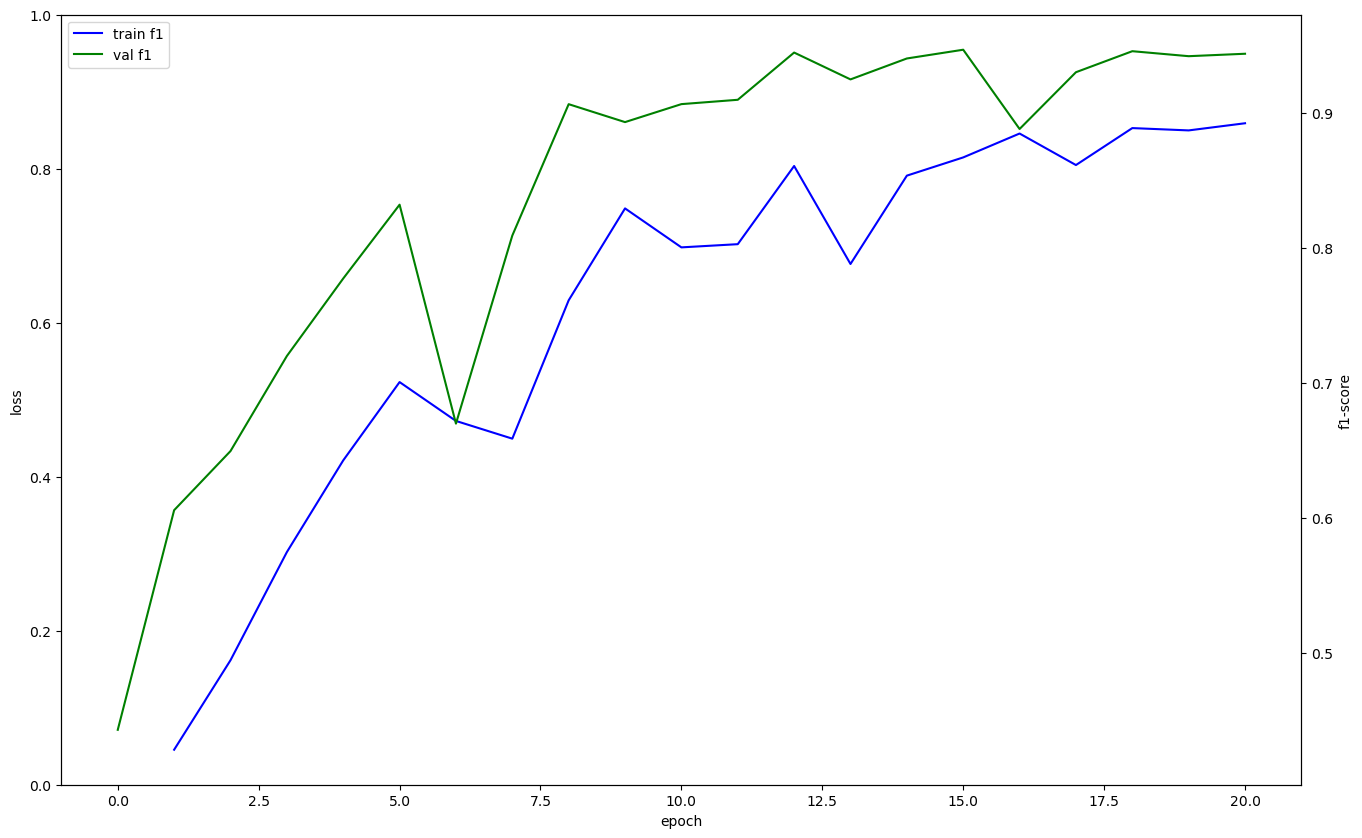

In [22]:
# Step 7.4: Bi-LSTM 모델 결과 시각화
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(bilstm_history.history['loss'], 'y', label='train loss')
loss_ax.plot(bilstm_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(bilstm_history.history['acc'], 'b', label='train acc')
acc_ax.plot(bilstm_history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(bilstm_history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(bilstm_history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

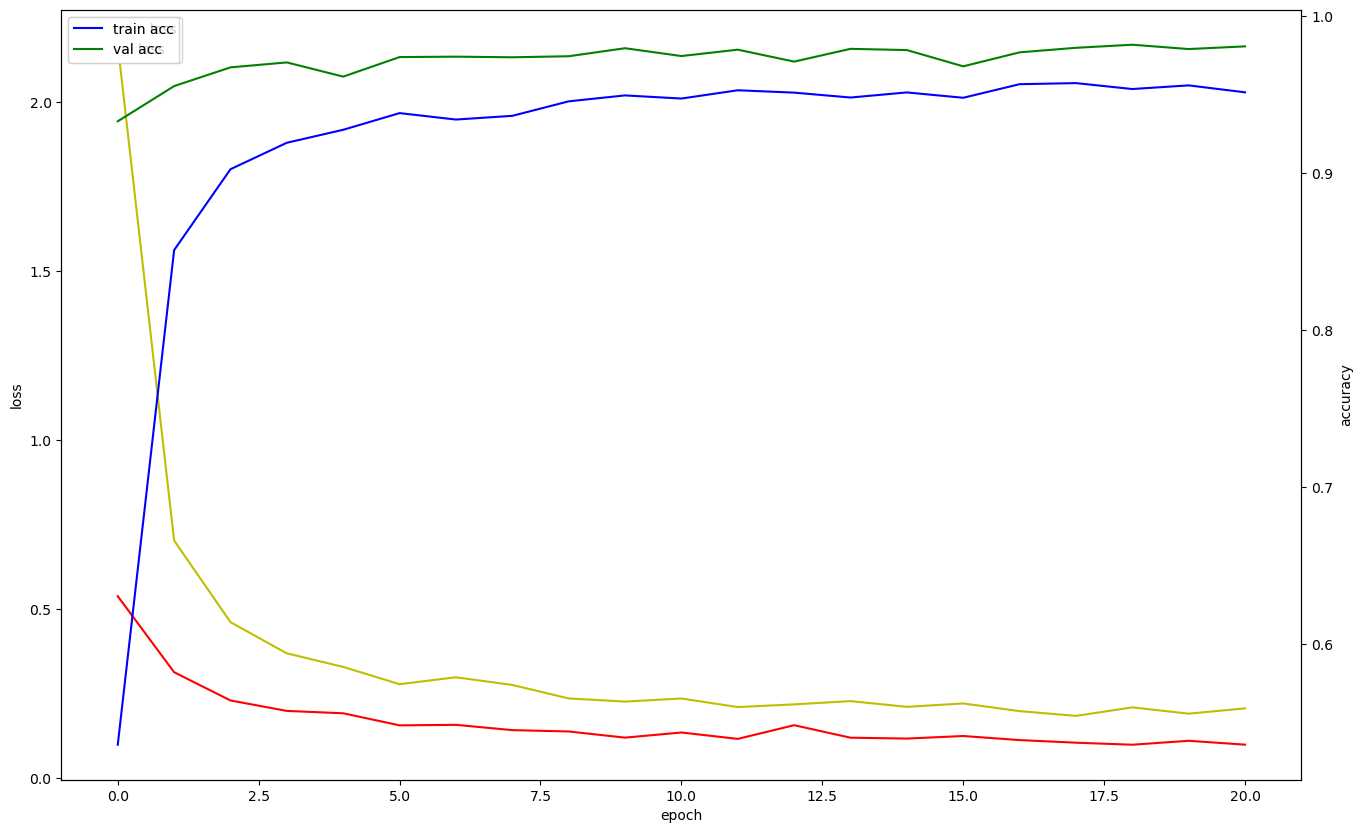

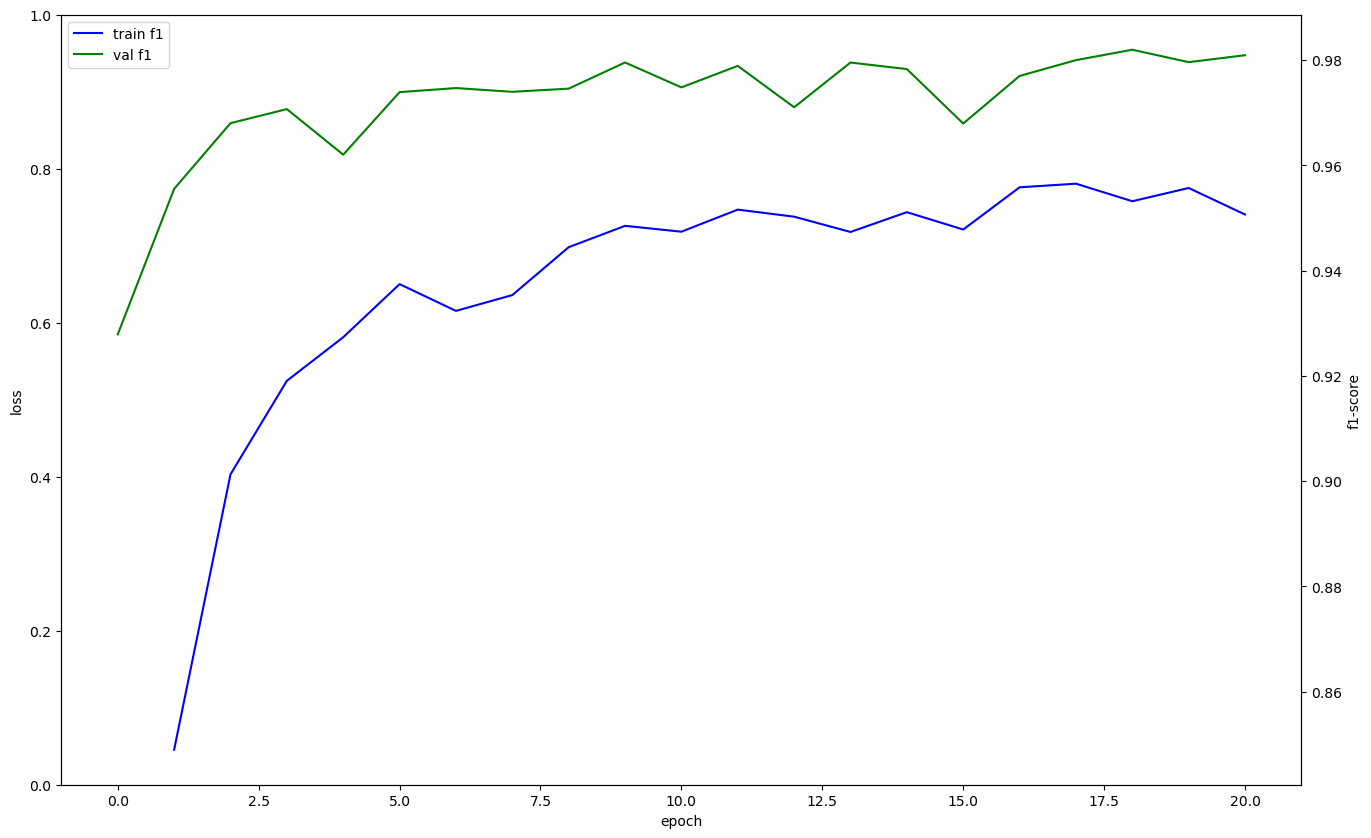

In [23]:
# Step 7.5: Bi-GRU 모델 결과 시각화
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(bigru_history.history['loss'], 'y', label='train loss')
loss_ax.plot(bigru_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(bigru_history.history['acc'], 'b', label='train acc')
acc_ax.plot(bigru_history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(bigru_history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(bigru_history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

In [25]:
# Step 8.1: LSTM 모델 평가 및 혼동 행렬 계산
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/sign_language_classifier_lstm.h5', custom_objects={'metric_F1score': metric_F1score})

y_pred = model.predict(x_val)
confusion_matrix = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

print(confusion_matrix)

239/239 [==============================] - 1s 4ms/step
[[[7338    9]
  [  77  202]]

 [[7276   66]
  [   2  282]]

 [[7393    1]
  [   3  229]]

 [[7384    3]
  [   5  234]]

 [[7381    4]
  [   2  239]]

 [[7390    0]
  [   0  236]]

 [[7331   63]
  [  12  220]]

 [[7396    0]
  [   1  229]]

 [[7360   21]
  [   1  244]]

 [[7393    0]
  [  25  208]]

 [[7407    2]
  [   0  217]]

 [[7373    5]
  [   3  245]]

 [[7360    0]
  [   0  266]]

 [[7384    2]
  [   0  240]]

 [[7312   79]
  [   0  235]]

 [[7302   86]
  [   0  238]]

 [[7364    9]
  [   3  250]]

 [[7337   10]
  [   3  276]]

 [[7362    0]
  [   0  264]]

 [[7386    2]
  [   2  236]]

 [[7362   33]
  [  27  204]]

 [[7359   19]
  [  64  184]]

 [[7391    1]
  [  31  203]]

 [[7391    1]
  [  70  164]]

 [[7372    1]
  [  86  167]]

 [[7398    0]
  [   0  228]]

 [[7360   17]
  [  14  235]]

 [[7372   12]
  [  13  229]]

 [[7345    0]
  [   0  281]]

 [[7370    1]
  [   1  254]]

 [[7384    0]
  [   2  240]]]


In [26]:
# Step 8.2: GRU 모델 평가
gru_model = load_model('models/sign_language_classifier_gru.h5', custom_objects={'metric_F1score': metric_F1score})

y_pred_gru = gru_model.predict(x_val)
confusion_matrix_gru = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred_gru, axis=1))

print("GRU 모델 Confusion Matrix:")
print(confusion_matrix_gru)


239/239 [==============================] - 1s 3ms/step
GRU 모델 Confusion Matrix:
[[[7339    8]
  [   1  278]]

 [[7342    0]
  [   0  284]]

 [[7394    0]
  [   0  232]]

 [[7386    1]
  [   0  239]]

 [[7385    0]
  [   0  241]]

 [[7390    0]
  [   1  235]]

 [[7391    3]
  [  10  222]]

 [[7395    1]
  [   0  230]]

 [[7368   13]
  [   0  245]]

 [[7391    2]
  [  13  220]]

 [[7408    1]
  [   2  215]]

 [[7378    0]
  [   3  245]]

 [[7359    1]
  [   1  265]]

 [[7386    0]
  [   0  240]]

 [[7326   65]
  [   0  235]]

 [[7299   89]
  [   1  237]]

 [[7371    2]
  [   2  251]]

 [[7347    0]
  [   3  276]]

 [[7362    0]
  [   0  264]]

 [[7388    0]
  [   3  235]]

 [[7395    0]
  [  11  220]]

 [[7367   11]
  [   2  246]]

 [[7392    0]
  [   0  234]]

 [[7391    1]
  [  65  169]]

 [[7372    1]
  [  86  167]]

 [[7397    1]
  [   0  228]]

 [[7370    7]
  [   4  245]]

 [[7378    6]
  [   5  237]]

 [[7344    1]
  [   0  281]]

 [[7371    0]
  [   0  255]]

 [[7384    0]
  [   

In [27]:
# Step 8.3: 1D-CNN 모델 평가
cnn_model = load_model('models/sign_language_classifier_cnn.h5', custom_objects={'metric_F1score': metric_F1score})

y_pred_cnn = cnn_model.predict(x_val)
confusion_matrix_cnn = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred_cnn, axis=1))

print("1D-CNN 모델 Confusion Matrix:")
print(confusion_matrix_cnn)


239/239 [==============================] - 1s 2ms/step
1D-CNN 모델 Confusion Matrix:
[[[7344    3]
  [   0  279]]

 [[7342    0]
  [   0  284]]

 [[7392    2]
  [   0  232]]

 [[7387    0]
  [   2  237]]

 [[7385    0]
  [   0  241]]

 [[7390    0]
  [   0  236]]

 [[7390    4]
  [   0  232]]

 [[7396    0]
  [   0  230]]

 [[7376    5]
  [   3  242]]

 [[7393    0]
  [   6  227]]

 [[7409    0]
  [   0  217]]

 [[7378    0]
  [   0  248]]

 [[7360    0]
  [   1  265]]

 [[7386    0]
  [   0  240]]

 [[7358   33]
  [   0  235]]

 [[7363   25]
  [  23  215]]

 [[7372    1]
  [   0  253]]

 [[7346    1]
  [   1  278]]

 [[7362    0]
  [   0  264]]

 [[7388    0]
  [   0  238]]

 [[7395    0]
  [   3  228]]

 [[7377    1]
  [   2  246]]

 [[7392    0]
  [   0  234]]

 [[7392    0]
  [  33  201]]

 [[7350   23]
  [  25  228]]

 [[7398    0]
  [   0  228]]

 [[7377    0]
  [   1  248]]

 [[7382    2]
  [   0  242]]

 [[7345    0]
  [   0  281]]

 [[7371    0]
  [   0  255]]

 [[7384    0]
  [

In [28]:
# Step 8.4: Bi-LSTM 모델 평가
bilstm_model = load_model('models/sign_language_classifier_bilstm.h5', custom_objects={'metric_F1score': metric_F1score})

y_pred_bilstm = bilstm_model.predict(x_val)
confusion_matrix_bilstm = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred_bilstm, axis=1))

print("Bi-LSTM 모델 Confusion Matrix:")
print(confusion_matrix_bilstm)

239/239 [==============================] - 2s 6ms/step
Bi-LSTM 모델 Confusion Matrix:
[[[7337   10]
  [   5  274]]

 [[7342    0]
  [   4  280]]

 [[7394    0]
  [   0  232]]

 [[7387    0]
  [   0  239]]

 [[7383    2]
  [   7  234]]

 [[7390    0]
  [   0  236]]

 [[7307   87]
  [  22  210]]

 [[7396    0]
  [   0  230]]

 [[7371   10]
  [   3  242]]

 [[7389    4]
  [   9  224]]

 [[7403    6]
  [   2  215]]

 [[7378    0]
  [   0  248]]

 [[7357    3]
  [   4  262]]

 [[7386    0]
  [   0  240]]

 [[7314   77]
  [   1  234]]

 [[7302   86]
  [   0  238]]

 [[7366    7]
  [  16  237]]

 [[7306   41]
  [   3  276]]

 [[7362    0]
  [   0  264]]

 [[7388    0]
  [   0  238]]

 [[7391    4]
  [  22  209]]

 [[7329   49]
  [  91  157]]

 [[7390    2]
  [   1  233]]

 [[7392    0]
  [  79  155]]

 [[7373    0]
  [  86  167]]

 [[7398    0]
  [   0  228]]

 [[7365   12]
  [  12  237]]

 [[7381    3]
  [  39  203]]

 [[7344    1]
  [   1  280]]

 [[7370    1]
  [   0  255]]

 [[7382    2]
  

In [29]:
# Step 8.5: Bi-GRU 모델 평가
bigru_model = load_model('models/sign_language_classifier_bigru.h5', custom_objects={'metric_F1score': metric_F1score})

y_pred_bigru = bigru_model.predict(x_val)
confusion_matrix_bigru = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred_bigru, axis=1))

print("Bi-GRU 모델 Confusion Matrix:")
print(confusion_matrix_bigru)

239/239 [==============================] - 2s 5ms/step
Bi-GRU 모델 Confusion Matrix:
[[[7345    2]
  [   0  279]]

 [[7342    0]
  [   0  284]]

 [[7394    0]
  [   0  232]]

 [[7387    0]
  [   1  238]]

 [[7385    0]
  [   0  241]]

 [[7390    0]
  [   0  236]]

 [[7393    1]
  [   0  232]]

 [[7396    0]
  [   0  230]]

 [[7378    3]
  [   2  243]]

 [[7392    1]
  [   4  229]]

 [[7409    0]
  [   0  217]]

 [[7377    1]
  [   0  248]]

 [[7360    0]
  [   0  266]]

 [[7386    0]
  [   0  240]]

 [[7351   40]
  [   2  233]]

 [[7302   86]
  [   0  238]]

 [[7373    0]
  [   0  253]]

 [[7347    0]
  [   0  279]]

 [[7362    0]
  [   0  264]]

 [[7388    0]
  [   0  238]]

 [[7395    0]
  [   3  228]]

 [[7377    1]
  [   0  248]]

 [[7392    0]
  [   0  234]]

 [[7390    2]
  [  40  194]]

 [[7373    0]
  [  86  167]]

 [[7398    0]
  [   0  228]]

 [[7377    0]
  [   0  249]]

 [[7384    0]
  [   0  242]]

 [[7345    0]
  [   0  281]]

 [[7371    0]
  [   0  255]]

 [[7383    1]
  [

In [30]:
# Step 9: 모델 저장
import tensorflow as tf

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False  # Disable experimental lowering of tensor list ops.
tflite_model = converter.convert()

# Save the model.
with open('models/sign_language_classifier_lstm.tflite', 'wb') as f:
    f.write(tflite_model)

print("LSTM 모델 변환 및 저장 완료")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(gru_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False  # Disable experimental lowering of tensor list ops.
tflite_gru_model = converter.convert()

# Save the model.
with open('models/sign_language_classifier_gru.tflite', 'wb') as f:
    f.write(tflite_gru_model)

print("GRU 모델 변환 및 저장 완료")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False  # Disable experimental lowering of tensor list ops.
tflite_cnn_model = converter.convert()

# Save the model.
with open('models/sign_language_classifier_cnn.tflite', 'wb') as f:
    f.write(tflite_cnn_model)

print("1D-CNN 모델 변환 및 저장 완료")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(bilstm_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False  # Disable experimental lowering of tensor list ops.
tflite_bilstm_model = converter.convert()

# Save the model.
with open('models/sign_language_classifier_bilstm.tflite', 'wb') as f:
    f.write(tflite_bilstm_model)

print("Bi-LSTM 모델 변환 및 저장 완료")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(bigru_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False  # Disable experimental lowering of tensor list ops.
tflite_bigru_model = converter.convert()

# Save the model.
with open('models/sign_language_classifier_bigru.tflite', 'wb') as f:
    f.write(tflite_bigru_model)

print("Bi-GRU 모델 변환 및 저장 완료")

INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmpxkzbrpcm\assets


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmpxkzbrpcm\assets


LSTM 모델 변환 및 저장 완료


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmpu0ruhvxk\assets


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmpu0ruhvxk\assets


GRU 모델 변환 및 저장 완료


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmpe92nxe48\assets


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmpe92nxe48\assets


1D-CNN 모델 변환 및 저장 완료


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmp4j65_6o6\assets


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmp4j65_6o6\assets


Bi-LSTM 모델 변환 및 저장 완료


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmprqvjundg\assets


INFO:tensorflow:Assets written to: C:\Users\rbxo3\AppData\Local\Temp\tmprqvjundg\assets


Bi-GRU 모델 변환 및 저장 완료


In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Custom F1 Score Metric
def metric_F1score(y_true, y_pred):
    TP = tf.reduce_sum(y_true * tf.round(y_pred))
    FP = tf.reduce_sum((1 - y_true) * tf.round(y_pred))
    FN = tf.reduce_sum(y_true * (1 - tf.round(y_pred)))
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1score = 2 * precision * recall / (precision + recall)
    return F1score

# Helper function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [31]:
# Load models
models = {
    'LSTM': load_model('models/sign_language_classifier_lstm.h5', custom_objects={'metric_F1score': metric_F1score}),
    'GRU': load_model('models/sign_language_classifier_gru.h5', custom_objects={'metric_F1score': metric_F1score}),
    '1D-CNN': load_model('models/sign_language_classifier_cnn.h5', custom_objects={'metric_F1score': metric_F1score}),
    'Bi-LSTM': load_model('models/sign_language_classifier_bilstm.h5', custom_objects={'metric_F1score': metric_F1score}),
    'Bi-GRU': load_model('models/sign_language_classifier_bigru.h5', custom_objects={'metric_F1score': metric_F1score})
}

# Predict with each model
predictions = {}
for model_name, model in models.items():
    predictions[model_name] = model.predict(x_val)

239/239 [==============================] - 2s 8ms/step


Model: LSTM
Accuracy: 0.9414
F1 Score: 0.9405
Classification Report:
               precision    recall  f1-score   support

           ㄱ       0.96      0.72      0.82       279
           ㄴ       0.81      0.99      0.89       284
           ㄷ       1.00      0.99      0.99       232
           ㄹ       0.99      0.98      0.98       239
           ㅁ       0.98      0.99      0.99       241
           ㅂ       1.00      1.00      1.00       236
           ㅅ       0.78      0.95      0.85       232
           ㅇ       1.00      1.00      1.00       230
           ㅈ       0.92      1.00      0.96       245
           ㅊ       1.00      0.89      0.94       233
           ㅋ       0.99      1.00      1.00       217
           ㅌ       0.98      0.99      0.98       248
           ㅍ       1.00      1.00      1.00       266
           ㅎ       0.99      1.00      1.00       240
           ㅏ       0.75      1.00      0.86       235
           ㅑ       0.73      1.00      0.85       238
           

C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12593 (\N{HANGUL LETTER KIYEOK}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12596 (\N{HANGUL LETTER NIEUN}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12599 (\N{HANGUL LETTER TIKEUT}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12601 (\N{HANGUL LETTER RIEUL}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12609 (\N{HANGUL LETTER MIEUM}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12610 (\N{HANGUL LETTER PIEUP}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\l

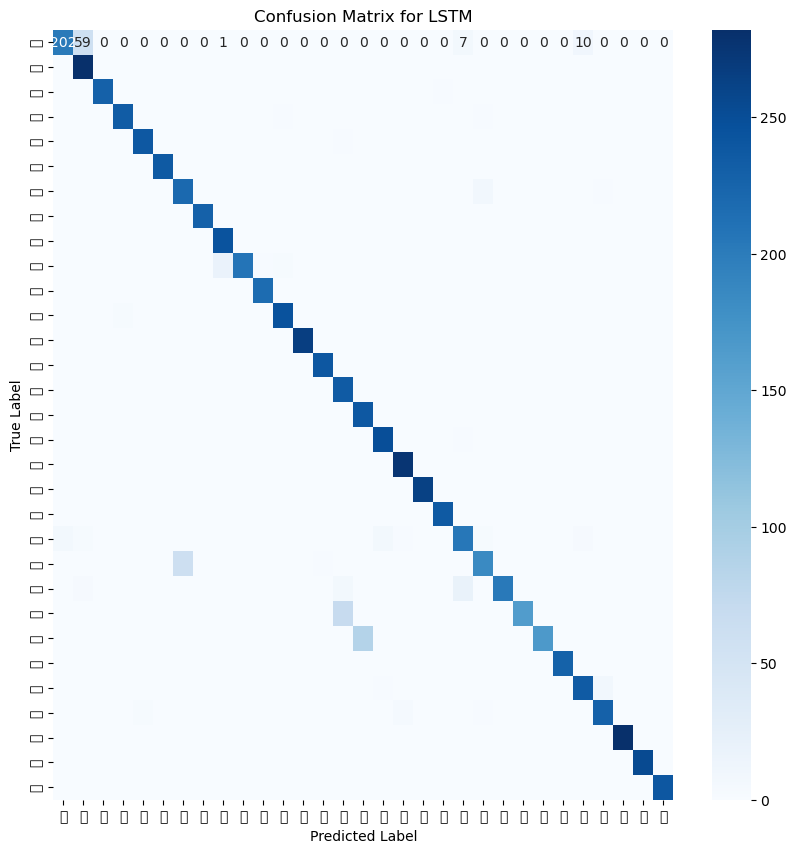

Model: GRU
Accuracy: 0.9719
F1 Score: 0.9715
Classification Report:
               precision    recall  f1-score   support

           ㄱ       0.97      1.00      0.98       279
           ㄴ       1.00      1.00      1.00       284
           ㄷ       1.00      1.00      1.00       232
           ㄹ       1.00      1.00      1.00       239
           ㅁ       1.00      1.00      1.00       241
           ㅂ       1.00      1.00      1.00       236
           ㅅ       0.99      0.96      0.97       232
           ㅇ       1.00      1.00      1.00       230
           ㅈ       0.95      1.00      0.97       245
           ㅊ       0.99      0.94      0.97       233
           ㅋ       1.00      0.99      0.99       217
           ㅌ       1.00      0.99      0.99       248
           ㅍ       1.00      1.00      1.00       266
           ㅎ       1.00      1.00      1.00       240
           ㅏ       0.78      1.00      0.88       235
           ㅑ       0.73      1.00      0.84       238
           ㅓ

C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12593 (\N{HANGUL LETTER KIYEOK}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12596 (\N{HANGUL LETTER NIEUN}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12599 (\N{HANGUL LETTER TIKEUT}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12601 (\N{HANGUL LETTER RIEUL}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12609 (\N{HANGUL LETTER MIEUM}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12610 (\N{HANGUL LETTER PIEUP}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\l

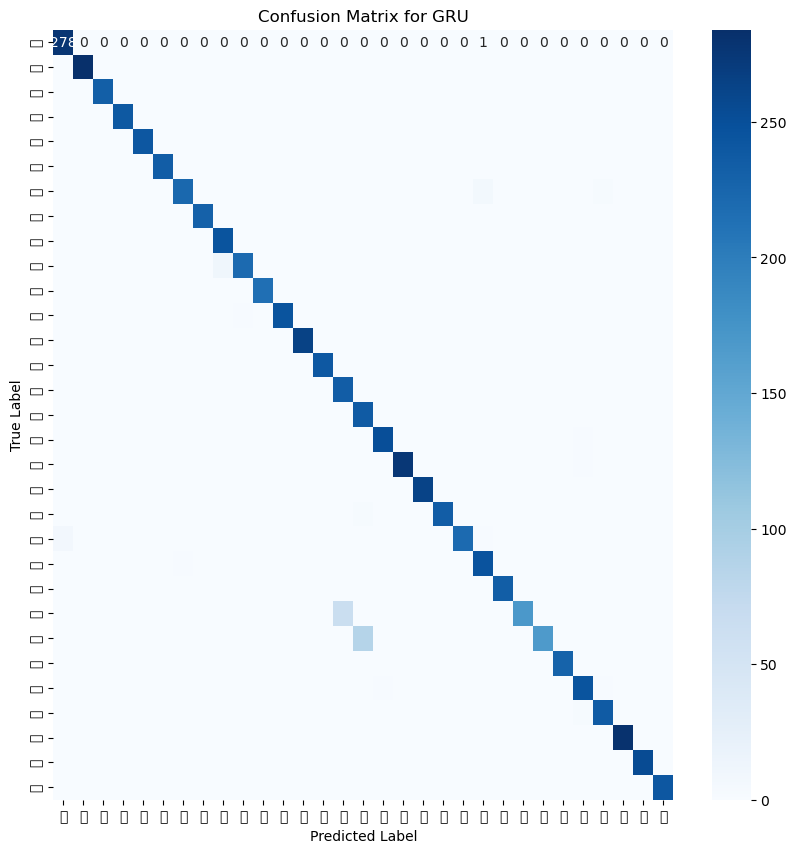

Model: 1D-CNN
Accuracy: 0.9869
F1 Score: 0.9869
Classification Report:
               precision    recall  f1-score   support

           ㄱ       0.99      1.00      0.99       279
           ㄴ       1.00      1.00      1.00       284
           ㄷ       0.99      1.00      1.00       232
           ㄹ       1.00      0.99      1.00       239
           ㅁ       1.00      1.00      1.00       241
           ㅂ       1.00      1.00      1.00       236
           ㅅ       0.98      1.00      0.99       232
           ㅇ       1.00      1.00      1.00       230
           ㅈ       0.98      0.99      0.98       245
           ㅊ       1.00      0.97      0.99       233
           ㅋ       1.00      1.00      1.00       217
           ㅌ       1.00      1.00      1.00       248
           ㅍ       1.00      1.00      1.00       266
           ㅎ       1.00      1.00      1.00       240
           ㅏ       0.88      1.00      0.93       235
           ㅑ       0.90      0.90      0.90       238
         

C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12593 (\N{HANGUL LETTER KIYEOK}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12596 (\N{HANGUL LETTER NIEUN}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12599 (\N{HANGUL LETTER TIKEUT}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12601 (\N{HANGUL LETTER RIEUL}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12609 (\N{HANGUL LETTER MIEUM}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12610 (\N{HANGUL LETTER PIEUP}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\l

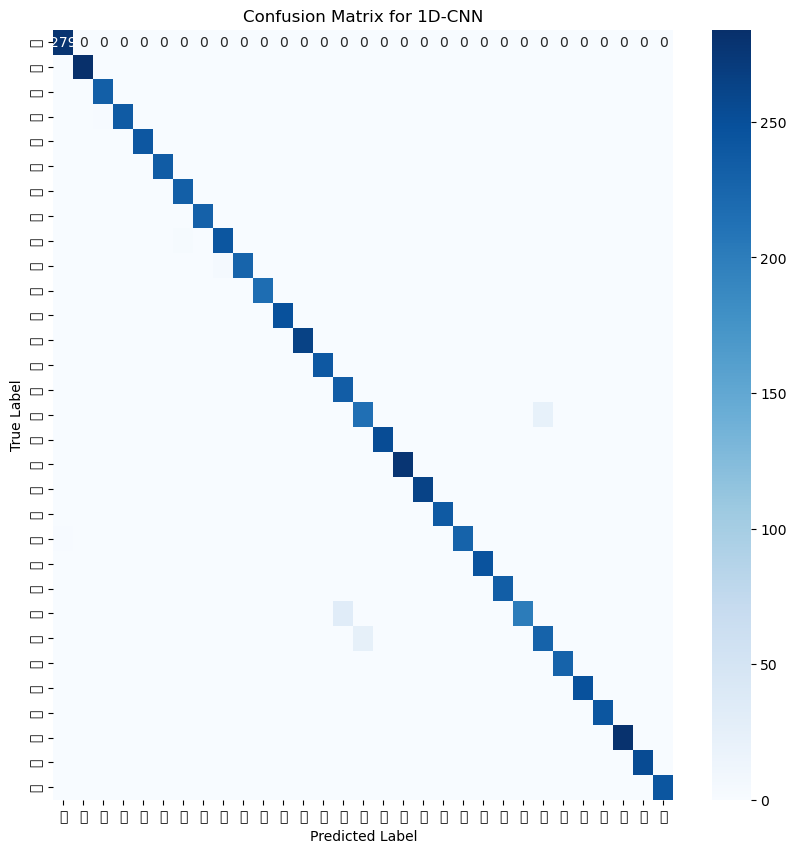

Model: Bi-LSTM
Accuracy: 0.9466
F1 Score: 0.9459
Classification Report:
               precision    recall  f1-score   support

           ㄱ       0.96      0.98      0.97       279
           ㄴ       1.00      0.99      0.99       284
           ㄷ       1.00      1.00      1.00       232
           ㄹ       1.00      1.00      1.00       239
           ㅁ       0.99      0.97      0.98       241
           ㅂ       1.00      1.00      1.00       236
           ㅅ       0.71      0.91      0.79       232
           ㅇ       1.00      1.00      1.00       230
           ㅈ       0.96      0.99      0.97       245
           ㅊ       0.98      0.96      0.97       233
           ㅋ       0.97      0.99      0.98       217
           ㅌ       1.00      1.00      1.00       248
           ㅍ       0.99      0.98      0.99       266
           ㅎ       1.00      1.00      1.00       240
           ㅏ       0.75      1.00      0.86       235
           ㅑ       0.73      1.00      0.85       238
        

C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12593 (\N{HANGUL LETTER KIYEOK}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12596 (\N{HANGUL LETTER NIEUN}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12599 (\N{HANGUL LETTER TIKEUT}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12601 (\N{HANGUL LETTER RIEUL}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12609 (\N{HANGUL LETTER MIEUM}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12610 (\N{HANGUL LETTER PIEUP}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\l

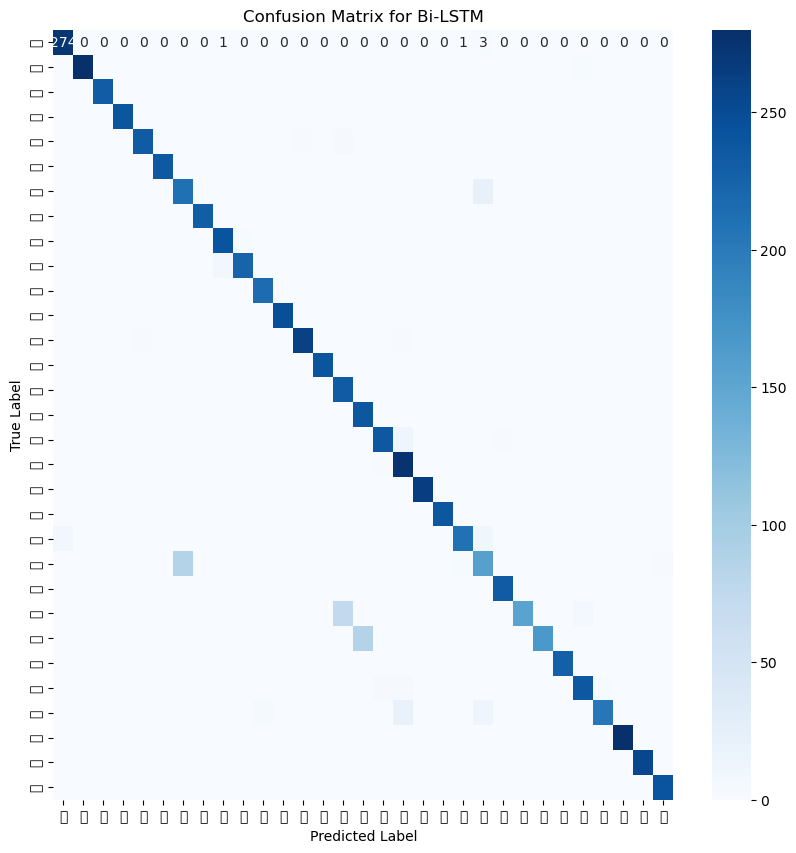

Model: Bi-GRU
Accuracy: 0.9819
F1 Score: 0.9816
Classification Report:
               precision    recall  f1-score   support

           ㄱ       0.99      1.00      1.00       279
           ㄴ       1.00      1.00      1.00       284
           ㄷ       1.00      1.00      1.00       232
           ㄹ       1.00      1.00      1.00       239
           ㅁ       1.00      1.00      1.00       241
           ㅂ       1.00      1.00      1.00       236
           ㅅ       1.00      1.00      1.00       232
           ㅇ       1.00      1.00      1.00       230
           ㅈ       0.99      0.99      0.99       245
           ㅊ       1.00      0.98      0.99       233
           ㅋ       1.00      1.00      1.00       217
           ㅌ       1.00      1.00      1.00       248
           ㅍ       1.00      1.00      1.00       266
           ㅎ       1.00      1.00      1.00       240
           ㅏ       0.85      0.99      0.92       235
           ㅑ       0.73      1.00      0.85       238
         

C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12593 (\N{HANGUL LETTER KIYEOK}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12596 (\N{HANGUL LETTER NIEUN}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12599 (\N{HANGUL LETTER TIKEUT}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12601 (\N{HANGUL LETTER RIEUL}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12609 (\N{HANGUL LETTER MIEUM}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12610 (\N{HANGUL LETTER PIEUP}) missing from current font.
  fig.canvas.draw()
C:\Users\rbxo3\anaconda3\l

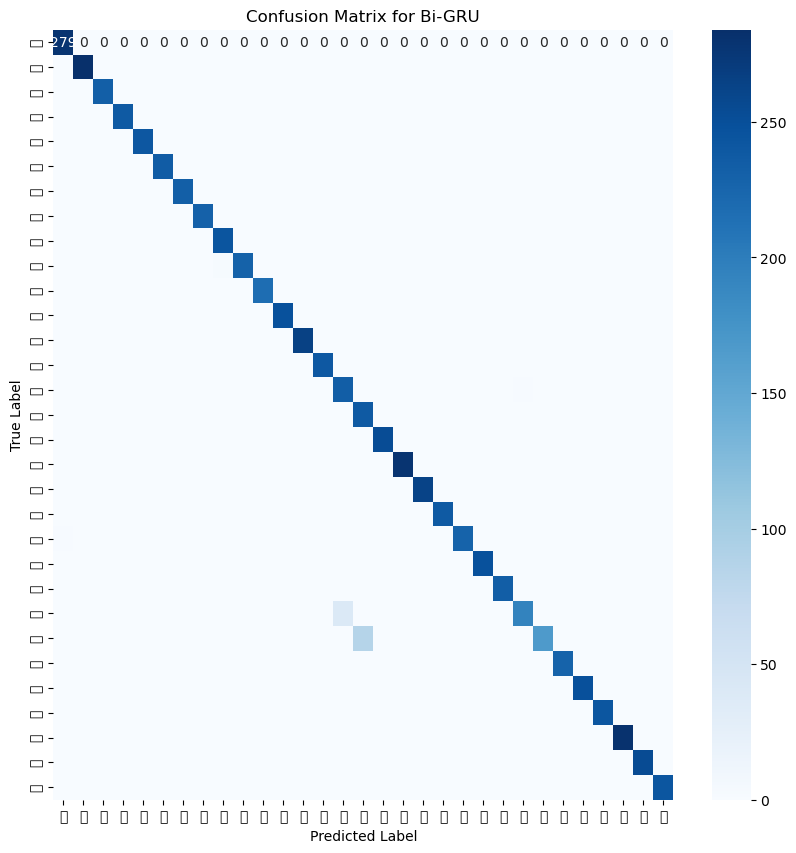

In [35]:
# Evaluate each model
for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Classification Report
    report = classification_report(y_true_classes, y_pred_classes, target_names=actions[:len(np.unique(y_true_classes))])

    # Accuracy and F1-Score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)
    plot_confusion_matrix(cm, classes=actions[:len(np.unique(y_true_classes))], title=f'Confusion Matrix for {model_name}')


C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\rbxo3\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


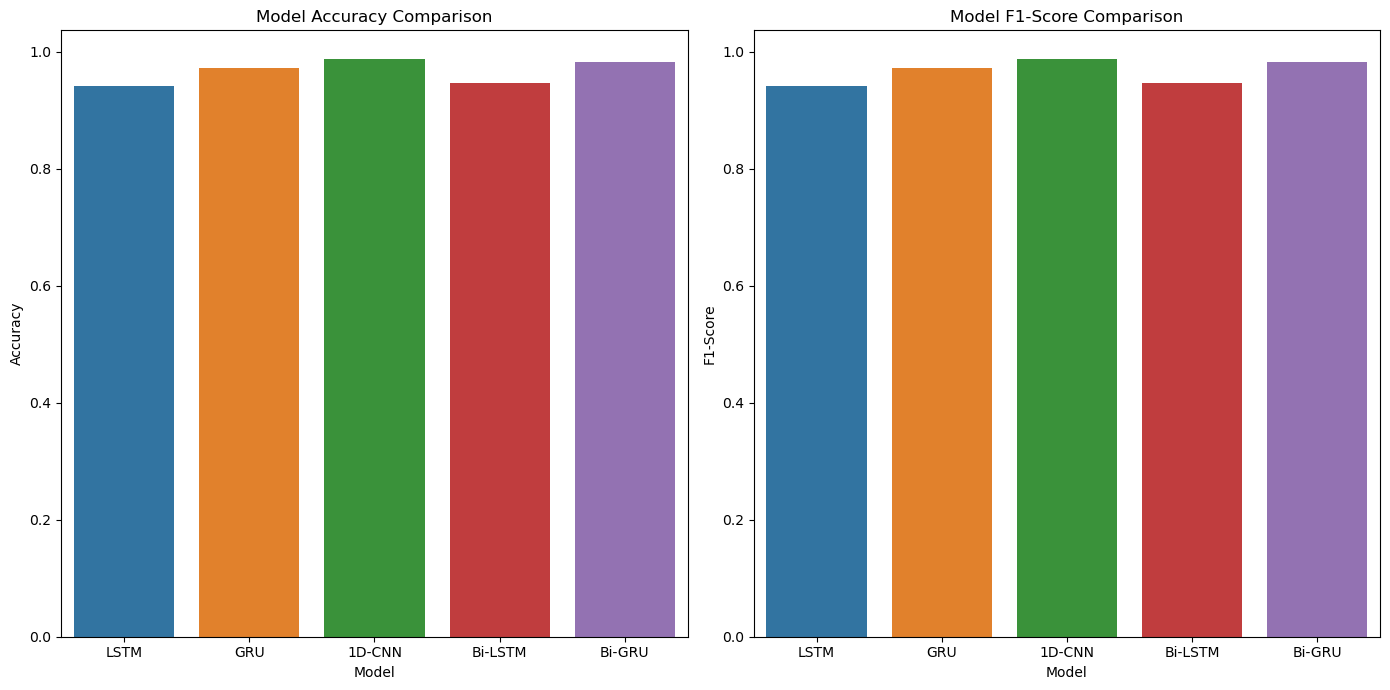

In [36]:
# Collect accuracy and F1-score for each model
accuracy_scores = []
f1_scores = []
model_names = []

for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    model_names.append(model_name)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Plot accuracy and F1-score comparison
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=model_names, y=accuracy_scores)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.barplot(x=model_names, y=f1_scores)
plt.title('Model F1-Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1-Score')

plt.tight_layout()
plt.show()

In [37]:
print("a")

a
